## Modules à importer

In [1]:
import math
import glob
import scipy
import pickle
import numpy as np
import pandas as pd
import iminuit as im
import ipywidgets as ipw
from snprop import age
from pymage import query
from snprop import survey
from variaIa import tools_ar
from variaIa.tools_ar import surveys, df_cons, df_nc, df_c, df_full
from mpl_toolkits.axes_grid1 import make_axes_locatable
from variaIa import massevol
from importlib import reload
from variaIa import stretchevol
from matplotlib.lines import Line2D
from pprint import PrettyPrinter
import matplotlib.pyplot as plt
import matplotlib as mpl
import random

#### Colormap definition

In [16]:
# create colormap
# ---------------

# create a colormap that consists of
# - 1/5 : custom colormap, ranging from white to the first color of the colormap
# - 4/5 : existing colormap

# set upper part: 4 * 256/4 entries
upper = mpl.cm.turbo(np.arange(256))

# set lower part: 1 * 256/4 entries
# - initialize all entries to 1 to make sure that the alpha channel (4th column) is 1
lower = np.ones((int(256/4),4))
# - modify the first three columns (RGB):
#   range linearly between white (1,1,1) and the first color of the upper colormap
for i in range(3):
    lower[:,i] = np.linspace(1, upper[0,i], lower.shape[0])

# combine parts of colormap
cmap = np.vstack((lower, upper))

# convert to matplotlib colormap
cmap_tpw = mpl.colors.ListedColormap(cmap, name='turbopw', N=cmap.shape[0])

## Définitions pandas, surveys et sélection de l'échantillon à utiliser

In [2]:
def set_survey(cons, su):
    global df
    if su == 'All':
        df = df_cons(cons)
    elif 'n' in su:
        df = df_cons(cons)[df_cons(cons)['survey'] != su.split('n')[-1]]
    else:
        df = df_cons(cons)[df_cons(cons)['survey'] == su]
    return df

int_set_su = ipw.interactive(set_survey, cons=tools_ar.cons, su=tools_ar.su)
display(int_set_su)

smap = plt.cm.get_cmap('cividis')
#smap = plt.cm.get_cmap('viridis')
colors = {'SNF': plt.cm.binary(0.9),
          'low-z': (1, 0, 0),
          'SDSS': smap(0.1),
          'PS1': smap(0.5),
          'SNLS': smap(0.8),
          'HST': smap(0.99),  # for cividis
          #'HST': smap(300),  # for viridis
          'All': (255/255, 51/255, 0/255)} 

def alphacolors(alpha, survey):
    return(colors[survey][0], colors[survey][1], colors[survey][2], alpha)

df_nHST = df_nc[df_nc['survey'] != 'HST']
df_nlowz = df_nc[df_nc['survey'] != 'low-z']

interactive(children=(Checkbox(value=False, description='Conservative'), Dropdown(description='Survey:', optio…

#### Check FITPROB density

In [3]:
d = pd.read_csv('../../../Data/sne/data_cheat.csv', sep=' ', index_col='CID')

[0.00104288, 0.00100543, 7.54696e-19]

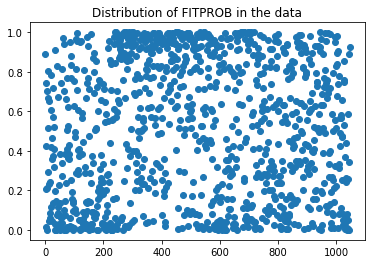

In [46]:
plt.scatter([i for i in range(len(d['FITPROB']))], d['FITPROB'])
plt.title('Distribution of FITPROB in the data')
plt.savefig('../../../Images/pdf/data_fitprob_distrib.pdf', bbox_inches='tight')
[np.min(d[d['IDSURVEY'] == i]['FITPROB']) for i in [1, 15, 4]]

In [47]:
len(d[(d['IDSURVEY'] == 4) & (d['zCMB'] < 0.60) & (d['FITPROB'] < 1e-3)])

9

## First `SNANA` implementation

In [5]:
fitprop = pd.read_csv('../../../Data/sims/First_run/FITOPT000.FITRES', sep=' ')

In [19]:
fitprop.columns

Index(['CID', 'CIDint', 'IDSURVEY', 'TYPE', 'FIELD', 'CUTFLAG_SNANA', 'zHEL',
       'zHELERR', 'zCMB', 'zCMBERR', 'zHD', 'zHDERR', 'VPEC', 'VPECERR',
       'MWEBV', 'HOST_LOGMASS', 'HOST_LOGMASS_ERR', 'HOST_sSFR',
       'HOST_sSFR_ERR', 'SNRMAX1', 'SNRMAX2', 'SNRMAX3', 'PKMJD', 'PKMJDERR',
       'x1', 'x1ERR', 'c', 'cERR', 'mB', 'mBERR', 'x0', 'x0ERR', 'COV_x1_c',
       'COV_x1_x0', 'COV_c_x0', 'NDOF', 'FITCHI2', 'FITPROB', 'SIM_TYPE_INDEX',
       'SIM_TEMPLATE_INDEX', 'SIM_LIBID', 'SIM_NGEN_LIBID', 'SIM_ZCMB',
       'SIM_ZFLAG', 'SIM_VPEC', 'SIM_DLMAG', 'SIM_PKMJD', 'SIM_x1', 'SIM_c',
       'SIM_alpha', 'SIM_beta', 'SIM_x0', 'SIM_mB', 'SIM_AV', 'SIM_RV',
       'SIM_HOSTLIB_sSFR', 'SIM_gammaDM', 'PROB_UNITY', 'Unnamed: 58'],
      dtype='object')

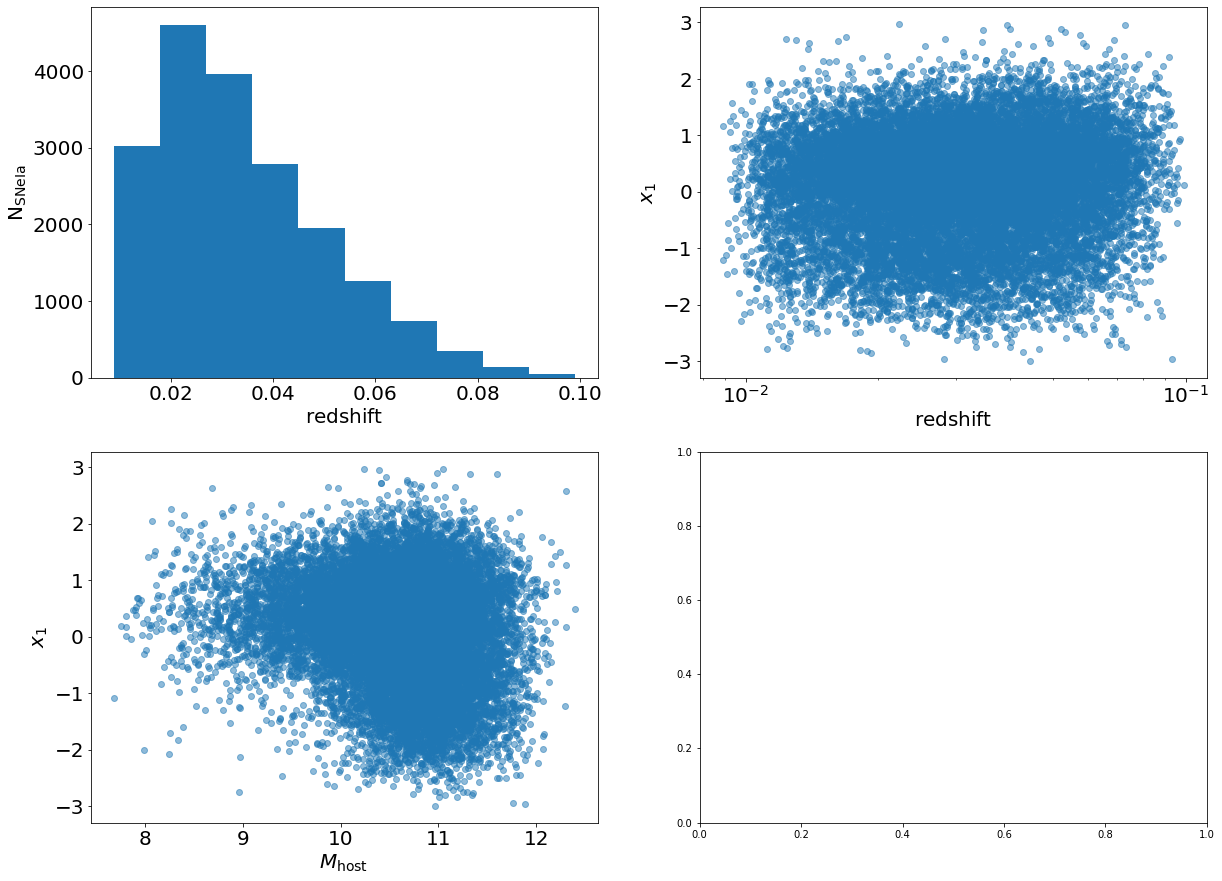

In [33]:
#fig = plt.figgure(figsize=[8, 5])
#ax1 = plt.subplots(121)

fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=[20, 15])

#fig = plt.figure(figsize=[8, 5])
#ax = fig.add_axes([0.1, 0.12, 0.6, 0.5])

ax1.hist(fitprop.zCMB.values)
ax2.scatter(fitprop.zCMB.values, fitprop.x1.values, alpha=.5)
ax2.set_xscale('log')
ax3.scatter(fitprop.HOST_LOGMASS, fitprop.x1, alpha=.5)

ax1.tick_params(labelsize=20)
ax2.tick_params(labelsize=20)
ax3.tick_params(labelsize=20)

ax1.set_xlabel(r"$\mathrm{redshift}$ ", fontsize=20)
ax1.set_ylabel(r"$\mathrm{N}_\mathrm{SNe Ia}$", fontsize=20)

ax2.set_xlabel(r"$\mathrm{redshift}$ ", fontsize=20)
ax2.set_ylabel(r"$x_1$", fontsize=20)

ax3.set_xlabel(r"$M_\mathrm{host}$ ", fontsize=20)
ax3.set_ylabel(r"$x_1$", fontsize=20)

fig.savefig('../../../Images/pdf/fitprop_test.pdf', bbox_inches='tight')
fig.savefig('../../../Images/png/fitprop_test.png', bbox_inches='tight', dpi=600)

## Second `SNANA` implementation: with HOSTLIB magshift=0.70

### Choose simu

In [3]:
sim_path = glob.glob("../../../Data/sims/NN*")
sc = ipw.Dropdown(options=sim_path,
                  description='Sim choice',
                  value=sim_path[0])

def set_fitprop(path):
    global fitprop_data
    if len(glob.glob(path + '/fitprop_data')) == 0:
        fitprop_data = []
    else:
        with open(path + '/fitprop_data', 'rb') as f:
            fitprop_data = pickle.load(f)

ipw.interactive(set_fitprop, path=sc)

interactive(children=(Dropdown(description='Sim choice', options=('../../../Data/sims/NN_G10_PANTH_V0', '../..…

### Convert `.fitres`

In [63]:
outputs = glob.glob(sc.value + '/PIP*/FITOPT000[!_treated]*')
fitprops = []
for i, output in enumerate(outputs):
    fitres = open(output, 'r+')
    fitres_lines = fitres.readlines()
    fitres.close()
    
    del(fitres_lines[8])
    del(fitres_lines[:7])
    fitres_lines[0] = fitres_lines[0][11:]
    fitres_lines[1:] = [line[4:] for line in fitres_lines[1:]]
    
    fitres = open(output.split('.FITRES')[0] + '_treated' + '.FITRES', 'w+')
    for line in fitres_lines:
        fitres.write(line)
    fitres.close() 
    fitprops.append(pd.read_csv(output.split('.FITRES')[0] + '_treated' + '.FITRES', sep=' '))
fitprop = fitprops[0]
for i in range(1, len(fitprops)):
    fitprop = fitprop.append(fitprops[i])

### Load selected

In [18]:
outputs = glob.glob(sc.value + '/PIP*/FITOPT000[!_treated]*')
fitprops = []
for output in outputs:
    fitprops.append(pd.read_csv(output.split('.FITRES')[0] + '_treated' + '.FITRES', sep=' '))
fitprop = fitprops[0]
for i in range(1, len(fitprops)):
    fitprop = fitprop.append(fitprops[i])

### Apply `x_1`, `c` cuts

In [19]:
fitprop = fitprop[(fitprop['x1'] > -3.0) & (fitprop['x1'] < 3.0) &
                  (fitprop['c'] > -0.3) & (fitprop['c'] < 0.3)]

### Get data ratio

In [20]:
surveys_size = {survey: len(df_full[df_full['survey'] == survey])
                for survey in ['SDSS', 'PS1', 'SNLS']}

In [21]:
fitprop_size = {survey: len(fitprop[fitprop['IDSURVEY'] == idsurvey])
                 for survey, idsurvey in zip(['SDSS', 'PS1', 'SNLS'],
                                             [1, 15, 4])}

In [22]:
todraw = {'SNLS': int(np.min([fitprop_size['SDSS']*surveys_size['SNLS']
                                                  /surveys_size['SDSS'],
                              fitprop_size['PS1']*surveys_size['SNLS']
                                                 /surveys_size['PS1'],
                              fitprop_size['SNLS']]))}

In [23]:
todraw['SDSS'] = int(todraw['SNLS']*surveys_size['SDSS']
                                   /surveys_size['SNLS'])
todraw['PS1'] = int(todraw['SNLS']*surveys_size['PS1']
                                  /surveys_size['SNLS'])

In [24]:
fitprop_sub = [fitprop[fitprop['IDSURVEY'] == idsurvey].sample(todraw[survey])
               for idsurvey, survey in zip([1, 15, 4], ['SDSS', 'PS1', 'SNLS'])]
fitprop_data = pd.concat(fitprop_sub)

### Save cut and sampled data

In [25]:
pickle.dump(fitprop_data, open(sc.value + '/fitprop_data', 'wb'))

### Now plot!

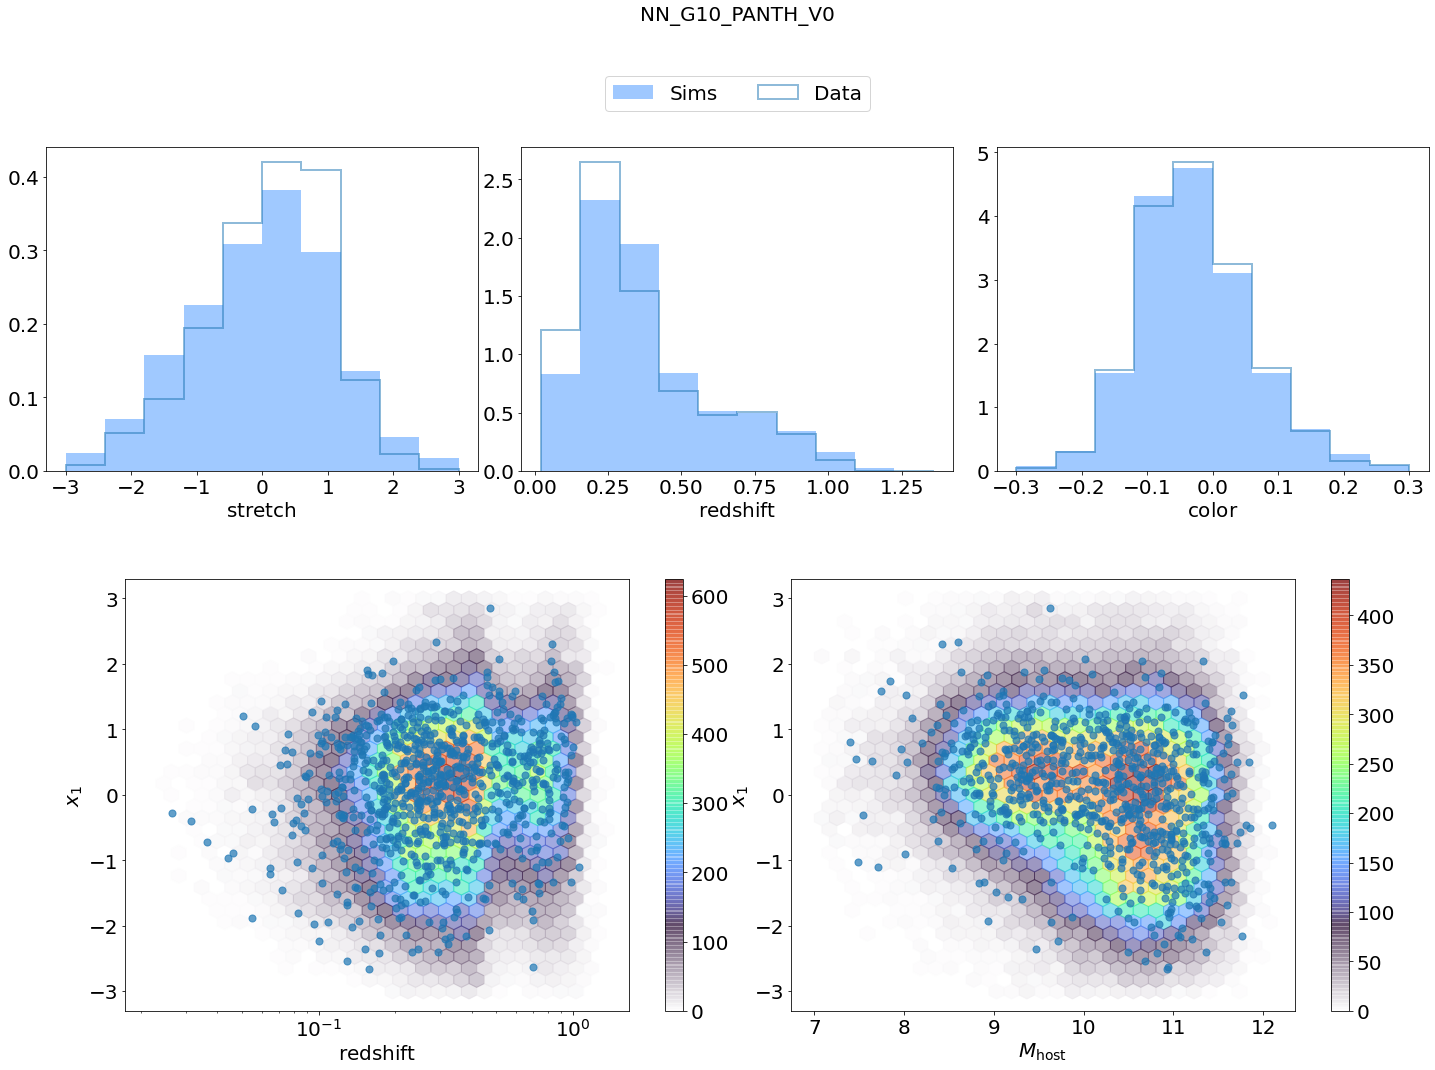

In [51]:
fig = plt.figure(figsize=[20, 15])

width_plot_cb = 0.35
space_cb = 0.025
width_cb = 0.0125
xmin_bottom = 0.075
ymin_bottom = 0.05
height_plot_cb = 0.40

xmin_top = 0.02
ymin_top = 0.15 + height_plot_cb
width_plot = 0.30
space_plot = 0.03
height_plot = 0.30

ax4 = fig.add_axes([xmin_top, ymin_top,
                    width_plot, height_plot])

ax1 = fig.add_axes([ax4.get_position().get_points()[1][0] + space_plot, ymin_top,
                    width_plot, height_plot])

ax5 = fig.add_axes([ax1.get_position().get_points()[1][0] + space_plot, ymin_top,
                    width_plot, height_plot])

ax2 = fig.add_axes([xmin_bottom, ymin_bottom,
                    width_plot_cb, height_plot_cb])
axb = fig.add_axes([ax2.get_position().get_points()[1][0] + space_cb, ymin_bottom,
                    width_cb, height_plot_cb])

ax3 = fig.add_axes([axb.get_position().get_points()[1][0] + 3*space_cb, ymin_bottom,
                    width_plot_cb, height_plot_cb])
axc = fig.add_axes([ax3.get_position().get_points()[1][0] + space_cb, ymin_bottom,
                    width_cb, height_plot_cb])

smap_v = plt.cm.get_cmap('viridis')

df_full_data = df_full[~df_full['survey'].isin(['SNF', 'HST'])]

color_data = 'C0'

#############################################################################

prophist = dict(alpha=.5, density=True)

_, bins, _ = ax1.hist(fitprop_data.zCMB,
                      histtype='stepfilled',
                      facecolor=cmap_tpw(0.35),
                      edgecolor=None,
                      label='Sims',
                      **prophist)

ax1.hist(df_full_data.redshifts,
         bins=bins,
         histtype='step', lw=2,
         color=color_data,
         label='Data',
         **prophist)

_, bins, _ = ax4.hist(fitprop_data.x1,
                      histtype='stepfilled',
                      facecolor=cmap_tpw(0.35),
                      edgecolor=None,
                      label='Sims',
                      **prophist)

ax4.hist(df_full_data.stretchs,
         bins=bins,
         histtype='step', lw=2,
         color=color_data,
         label='Data',
         **prophist)


_, bins, _ = ax5.hist(fitprop_data.c,
                      histtype='stepfilled',
                      facecolor=cmap_tpw(0.35),
                      edgecolor=None,
                      label='Sims',
                      **prophist)

ax5.hist(df_full_data.colors,
         bins=bins,
         histtype='step', lw=2,
         color=color_data,
         label='Data',
         **prophist)

#############################################################################

prop2d = dict(alpha=.5, gridsize=30, cmap=cmap_tpw)


hb2 = ax2.hexbin(fitprop_data.zCMB,
                 fitprop_data.x1,
                 xscale='log',
                 **prop2d)
ax2.set_xscale('log')

cb2 = fig.colorbar(hb2, cax=axb)

prop = dict(marker="o", s=50, lw=1, alpha=.7, color=color_data)

ax2.scatter(df_full_data.redshifts,
            df_full_data.stretchs,
            label='Data', **prop)

#############################################################################

fitprop_data_mass7 = fitprop_data[fitprop_data['HOST_LOGMASS'] > 7]
df_full_data_mass7 = df_full_data[df_full_data['hostmass'] > 7]

hb3 = ax3.hexbin(fitprop_data_mass7.HOST_LOGMASS,
                 fitprop_data_mass7.x1,
                 **prop2d)

cb3 = fig.colorbar(hb3, cax=axc)

ax3.scatter(df_full_data_mass7.hostmass,
            df_full_data_mass7.stretchs,
            label='Data', **prop)
#############################################################################

ax1.tick_params(labelsize=20)
ax4.tick_params(labelsize=20)
ax5.tick_params(labelsize=20)
ax2.tick_params(labelsize=20)
cb2.ax.tick_params(labelsize=20)
ax3.tick_params(labelsize=20)
cb3.ax.tick_params(labelsize=20)

ax1.set_xlabel(r"$\mathrm{redshift}$ ", fontsize=20)
#ax1.set_ylabel(r"$\mathrm{N}_\mathrm{SNe Ia}$", fontsize=20)

ax4.set_xlabel(r"$\mathrm{stretch}$ ", fontsize=20)
#ax4.set_ylabel(r"$\mathrm{N}_\mathrm{SNe Ia}$", fontsize=20)

ax5.set_xlabel(r"$\mathrm{color}$ ", fontsize=20)
#ax5.set_ylabel(r"$\mathrm{N}_\mathrm{SNe Ia}$", fontsize=20)

ax2.set_xlabel(r"$\mathrm{redshift}$ ", fontsize=20)
ax2.set_ylabel(r"$x_1$", fontsize=20)
#cb2.set_label('counts', fontsize=20)

ax3.set_xlabel(r"$M_\mathrm{host}$ ", fontsize=20)
ax3.set_ylabel(r"$x_1$", fontsize=20)
#cb3.set_label('counts', fontsize=20)

ax1.legend(fontsize=20, ncol=2,
           loc='upper center',
           bbox_to_anchor=(0.5, 1.0, 0.0, 0.25))

fig.suptitle(sc.value.split('/')[-1], fontsize=20)

fig.savefig('../../../Images/pdf/fitprop_data_' + sc.value.split('/')[-1] + '.pdf',
            bbox_inches='tight')
fig.savefig('../../../Images/png/fitprop_data_' + sc.value.split('/')[-1] + '.png',
            bbox_inches='tight', transparent=False)

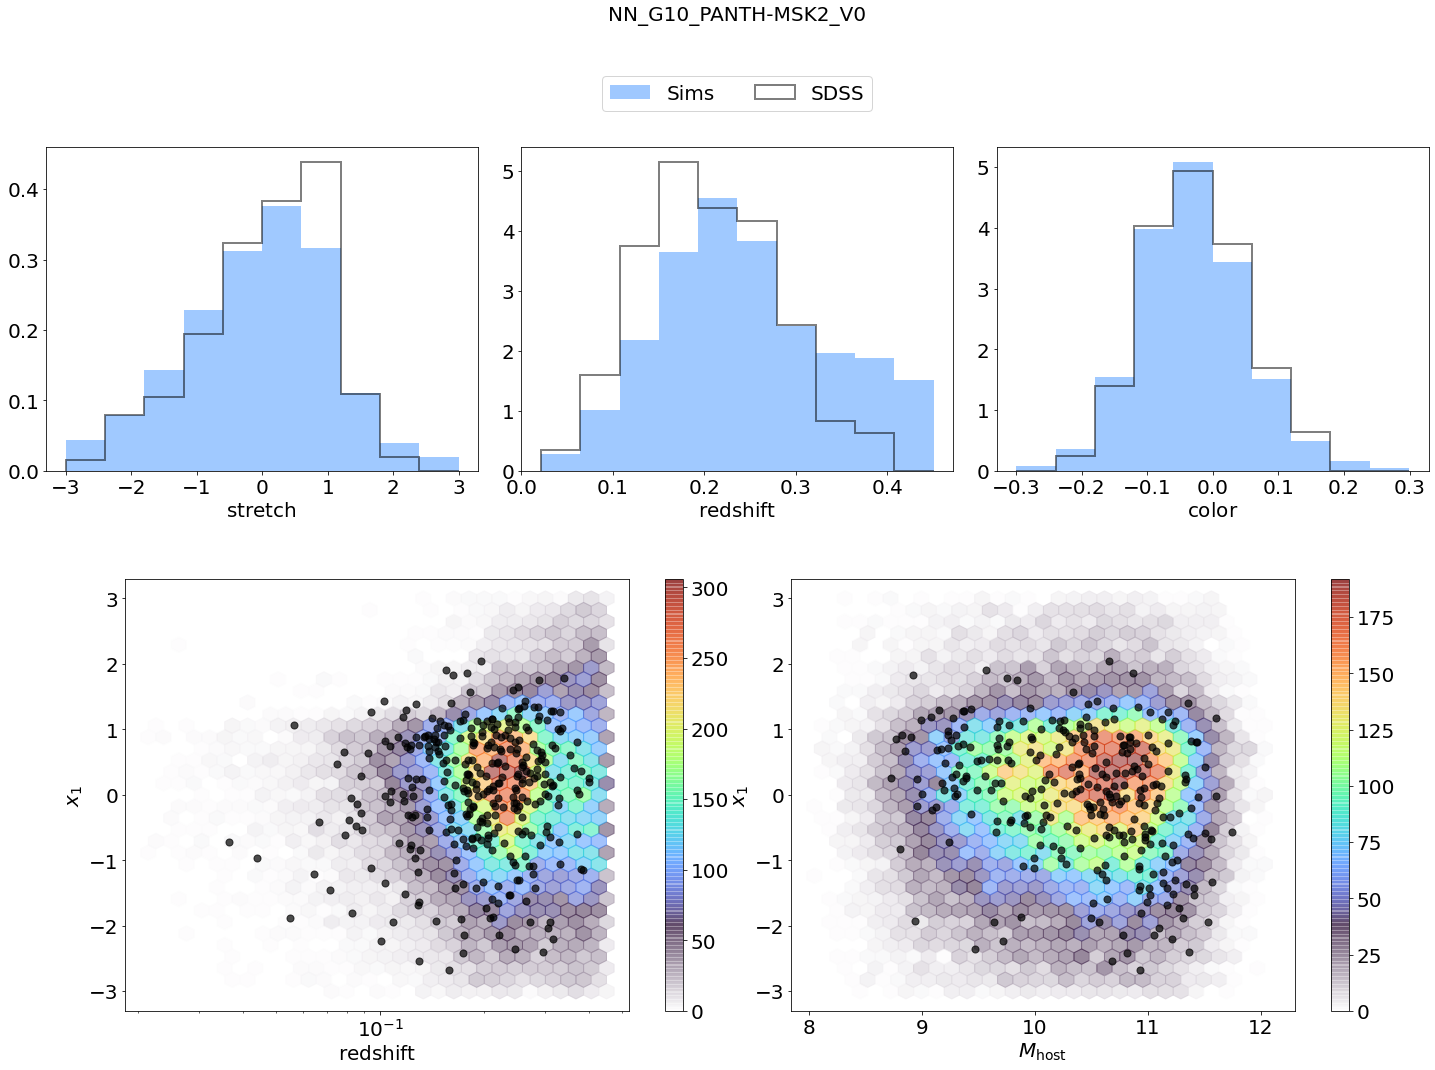

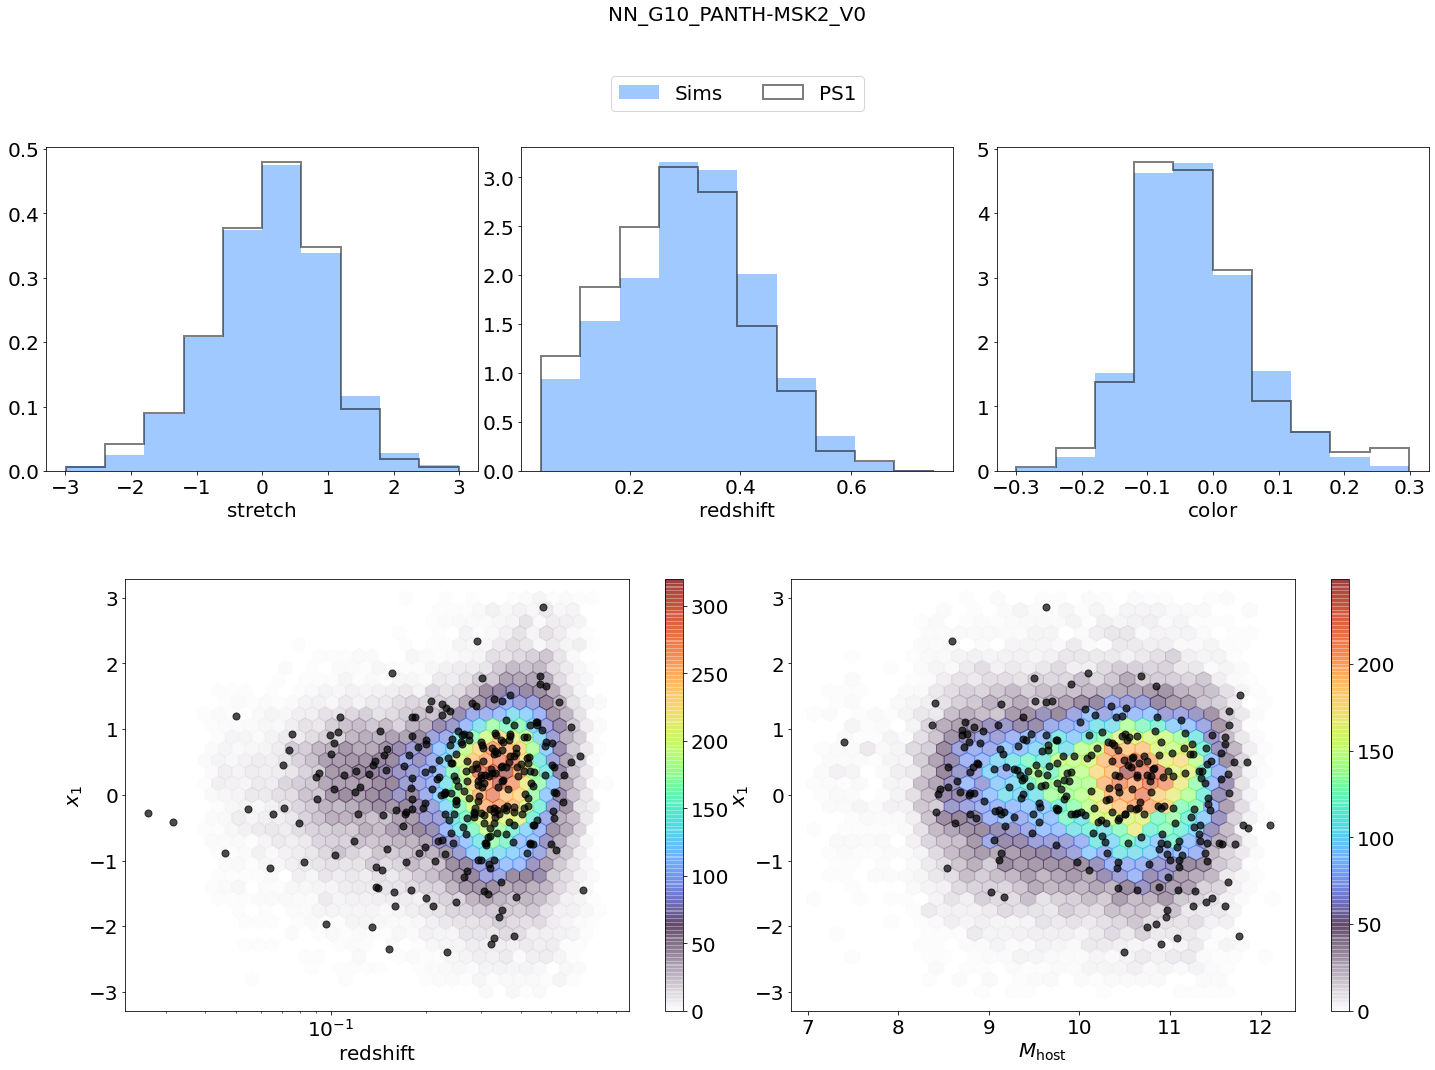

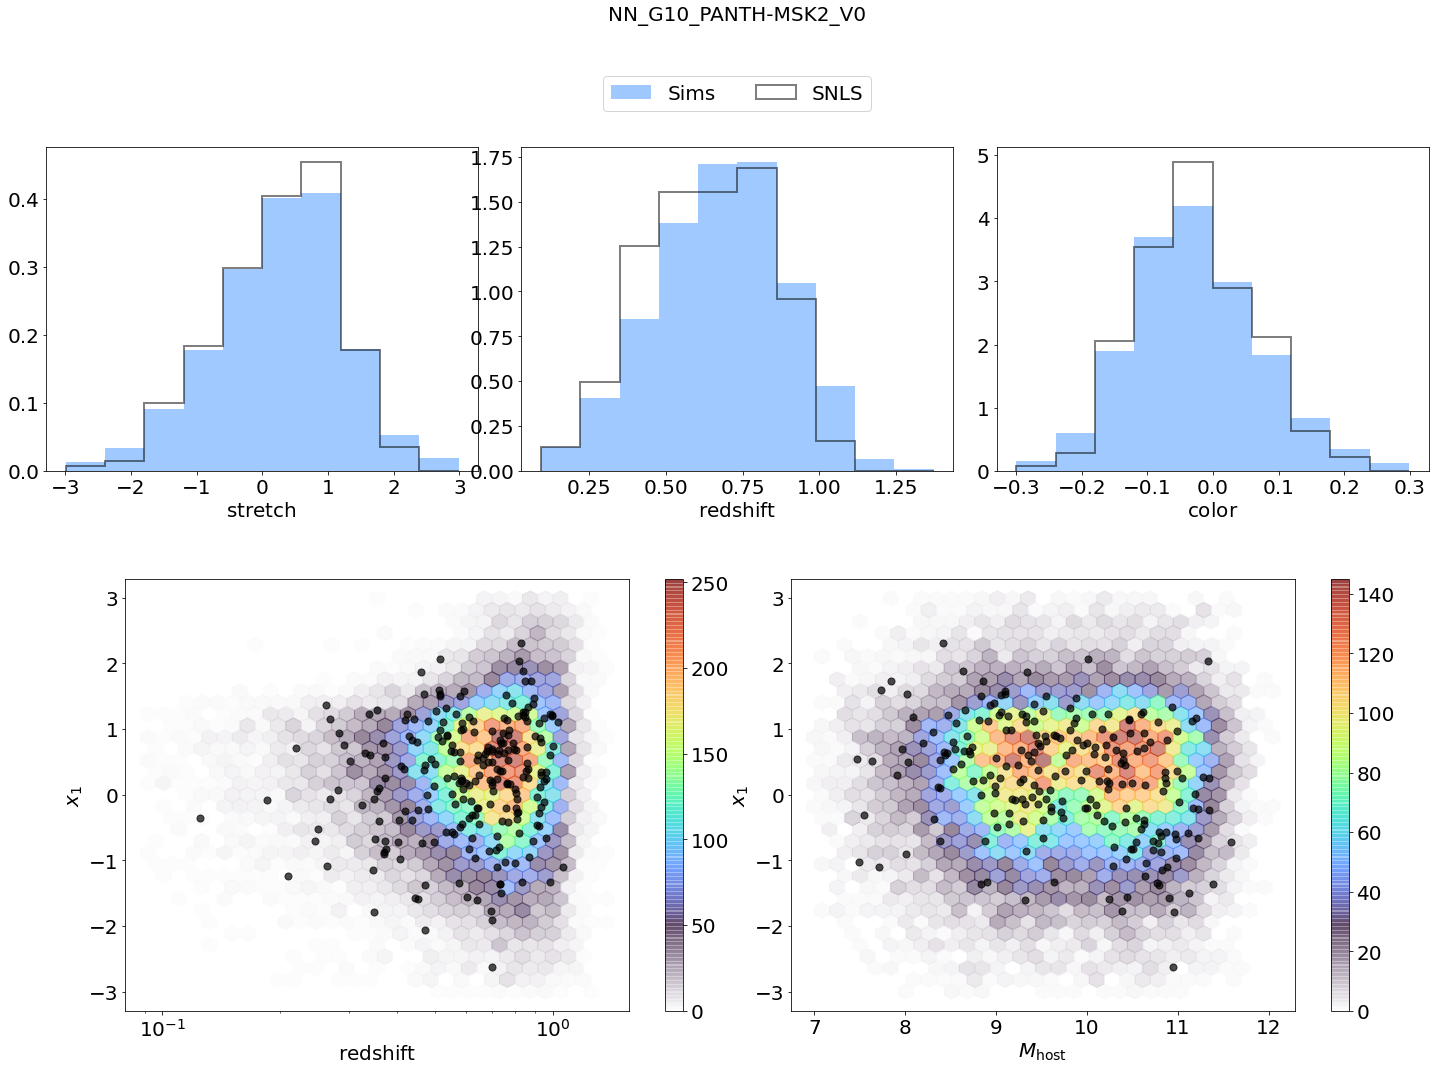

In [54]:
width_plot_cb = 0.35
space_cb = 0.025
width_cb = 0.0125
xmin_bottom = 0.075
ymin_bottom = 0.05
height_plot_cb = 0.40

xmin_top = 0.02
ymin_top = 0.15 + height_plot_cb
width_plot = 0.30
space_plot = 0.03
height_plot = 0.30

for i, zipped in enumerate(zip(surveys[1:-1], [1, 15, 4])):
    survey = zipped[0]
    idsurvey = zipped[-1]
    fig = plt.figure(figsize=[20, 15])
    
    ax4 = fig.add_axes([xmin_top, ymin_top,
                        width_plot, height_plot])
    
    ax1 = fig.add_axes([ax4.get_position().get_points()[1][0] + space_plot, ymin_top,
                        width_plot, height_plot])
    
    ax5 = fig.add_axes([ax1.get_position().get_points()[1][0] + space_plot, ymin_top,
                        width_plot, height_plot])
    
    ax2 = fig.add_axes([xmin_bottom, ymin_bottom,
                        width_plot_cb, height_plot_cb])
    axb = fig.add_axes([ax2.get_position().get_points()[1][0] + space_cb, ymin_bottom,
                        width_cb, height_plot_cb])
    
    ax3 = fig.add_axes([axb.get_position().get_points()[1][0] + 3*space_cb, ymin_bottom,
                        width_plot_cb, height_plot_cb])
    axc = fig.add_axes([ax3.get_position().get_points()[1][0] + space_cb, ymin_bottom,
                        width_cb, height_plot_cb])
    
    df_full_data_used = df_full[df_full['survey'] == survey]
    fitprop_data_used = fitprop_data[fitprop_data['IDSURVEY'] == idsurvey]
    
    color_data = 'k'
    
    #############################################################################
    
    prophist = dict(alpha=.5, density=True)
    
    _, bins, _ = ax1.hist(fitprop_data_used.zCMB,
                          histtype='stepfilled',
                          facecolor=cmap_tpw(0.35),
                          edgecolor=None,
                          label='Sims',
                          **prophist)
    
    ax1.hist(df_full_data_used.redshifts,
             bins=bins,
             histtype='step', lw=2,
             color=color_data,
             label=survey,
             **prophist)
    
    _, bins, _ = ax4.hist(fitprop_data_used.x1,
                          histtype='stepfilled',
                          facecolor=cmap_tpw(0.35),
                          edgecolor=None,
                          label='Sims',
                          **prophist)
    
    ax4.hist(df_full_data_used.stretchs,
             bins=bins,
             histtype='step', lw=2,
             color=color_data,
             label=survey,
             **prophist)
    
    
    _, bins, _ = ax5.hist(fitprop_data_used.c,
                          histtype='stepfilled',
                          facecolor=cmap_tpw(0.35),
                          edgecolor=None,
                          label='Sims',
                          **prophist)
    
    ax5.hist(df_full_data_used.colors,
             bins=bins,
             histtype='step', lw=2,
             color=color_data,
             label=survey,
             **prophist)
    
    #############################################################################
    
    prop2d = dict(alpha=.5, gridsize=30, cmap=cmap_tpw)
    
    
    hb2 = ax2.hexbin(fitprop_data_used.zCMB,
                     fitprop_data_used.x1,
                     xscale='log',
                     **prop2d)
    ax2.set_xscale('log')
    
    cb2 = fig.colorbar(hb2, cax=axb)
    
    prop = dict(marker="o", s=50, lw=1, alpha=.7, color=color_data)
    
    ax2.scatter(df_full_data_used.redshifts,
                df_full_data_used.stretchs,
                label=survey, **prop)
    
    #############################################################################
    
    fitprop_data_used_mass7 = fitprop_data_used[fitprop_data_used['HOST_LOGMASS'] > 7]
    df_full_data_used_mass7 = df_full_data_used[df_full_data_used['hostmass'] > 7]
    
    hb3 = ax3.hexbin(fitprop_data_used_mass7.HOST_LOGMASS,
                     fitprop_data_used_mass7.x1,
                     **prop2d)
    
    cb3 = fig.colorbar(hb3, cax=axc)
    
    ax3.scatter(df_full_data_used_mass7.hostmass,
                df_full_data_used_mass7.stretchs,
                label=survey, **prop)
    #############################################################################
    
    ax1.tick_params(labelsize=20)
    ax4.tick_params(labelsize=20)
    ax5.tick_params(labelsize=20)
    ax2.tick_params(labelsize=20)
    cb2.ax.tick_params(labelsize=20)
    ax3.tick_params(labelsize=20)
    cb3.ax.tick_params(labelsize=20)
    
    ax1.set_xlabel(r"$\mathrm{redshift}$ ", fontsize=20)
    #ax1.set_ylabel(r"$\mathrm{N}_\mathrm{SNe Ia}$", fontsize=20)
    
    ax4.set_xlabel(r"$\mathrm{stretch}$ ", fontsize=20)
    #ax4.set_ylabel(r"$\mathrm{N}_\mathrm{SNe Ia}$", fontsize=20)
    
    ax5.set_xlabel(r"$\mathrm{color}$ ", fontsize=20)
    #ax5.set_ylabel(r"$\mathrm{N}_\mathrm{SNe Ia}$", fontsize=20)
    
    ax2.set_xlabel(r"$\mathrm{redshift}$ ", fontsize=20)
    ax2.set_ylabel(r"$x_1$", fontsize=20)
    #cb2.set_label('counts', fontsize=20)
    
    ax3.set_xlabel(r"$M_\mathrm{host}$ ", fontsize=20)
    ax3.set_ylabel(r"$x_1$", fontsize=20)
    #cb3.set_label('counts', fontsize=20)
    
    ax1.legend(fontsize=20, ncol=2,
               loc='upper center',
               bbox_to_anchor=(0.5, 1.0, 0.0, 0.25))
    
    fig.suptitle(sc.value.split('/')[-1], fontsize=20)
    
    fig.savefig('../../../Images/pdf/fitprop_data_' + sc.value.split('/')[-1]
                + '_' + survey + '.pdf',
                bbox_inches='tight')
    fig.savefig('../../../Images/png/fitprop_data_' + sc.value.split('/')[-1]
                + '_' + survey + '.png',
                bbox_inches='tight', transparent=False)

## `age` module testing

In [2]:
pdmodel = age.PrompDelayModel()
pdmodel.draw_sample(z=0.04, size=1000)

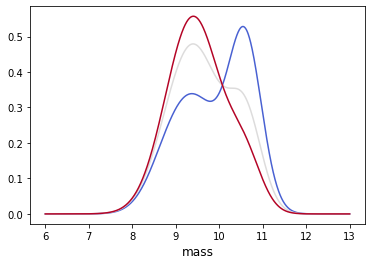

In [6]:
fig = pdmodel.show_pdf("mass", z=[0.05, 0.5, 1], zmax=1)

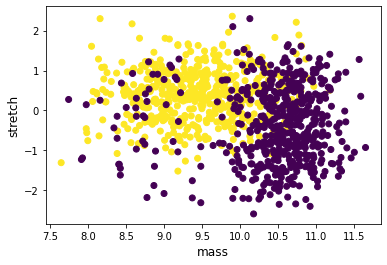

In [13]:
fig = pdmodel.show_scatter("mass","stretch", colorkey="age")

## Fit mass Brodie

NameError: name 'colors' is not defined

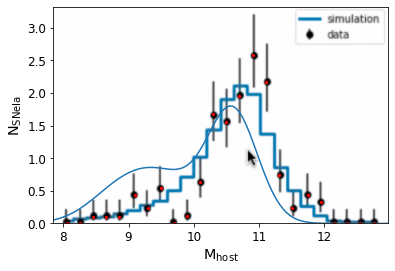

In [51]:
img = plt.imread("../../../Images/png/mass_hist_lowz_crop_zero.png")
fig, ax = plt.subplots()

Mmin = 7.85
Mmax = 12.98
Cmin = 0
Cmax = 170
f = 85.185

Mlist = [8.05, 8.25, 8.45, 8.65, 8.85,
         9.1, 9.3, 9.5, 9.7, 9.9,
         10.1, 10.3, 10.5, 10.7, 10.9,
         11.1, 11.3, 11.5, 11.75, 11.95,
         12.15, 12.35, 12.55, 12.76]

ax.scatter(Mlist,
           np.asarray([0, 0, 8, 8, 8,
                       37, 20, 46, 0, 10,
                       54, 143, 132, 166, 220,
                       185, 63, 20, 37, 28,
                       1, 0, 0, 0])/f,
          color='red', s=5)
ax.imshow(img, extent=[Mmin, Mmax, 0, 3.32])
          #[7.81, 12.94, 0, 170])

#ax.set_xlim([7.81, 12.94])
#ax.set_ylim([0, 170])

ax.tick_params(labelsize=12)

ax.set_xlabel(r'$\mathrm{M}_\mathrm{host}$', fontsize = 'x-large')
ax.set_ylabel(r"$\mathrm{N}_\mathrm{SNe Ia}$", fontsize="x-large")

def pdf_mass(x, fprompt):
    prompt_pdf = scipy.stats.norm.pdf(x,
                                      loc=9.41,
                                      scale=0.62)

    delay_pdf1 = scipy.stats.norm.pdf(x,
                                      loc=10.60,
                                      scale=0.38)

    delay_pdf2 = scipy.stats.norm.pdf(x,
                                      loc=8.74,
                                      scale=0.43)

    return(fprompt * prompt_pdf +
           (1-fprompt) * (0.90*delay_pdf1 + (1-0.90)*delay_pdf2))

def loglikepdf_mass(fprompt):
    return -2*np.sum(np.log(pdf_mass(Mlist, fprompt)))

def minimize_pdf_mass(print_level=0, **kwargs):
    '''Renvoie la meilleure valeur des paramètres'''
    m_tot = im.Minuit(loglikepdf_mass,
                      print_level=print_level,
                      pedantic=False,
                      fprompt=0.1,
                      **kwargs)
    migrad_out = m_tot.migrad()
    return(m_tot)

bestfit_mass = minimize_pdf_mass().values

xlin = np.linspace(7.85, 12.98, 100)
ax.plot(xlin, 3*pdf_mass(xlin, bestfit_mass['fprompt']))

ls = ['-', '--', ':']

for i, survey in enumerate(surveys[1:2]):
    df_ncused = df_nc[df_nc['survey'] == survey]
    where = df_ncused['hostmass'] > 8
    df_cused = df_c[df_c['survey'] == survey]

    ax.hist(df_ncused[where].hostmass, bins=20,
            weights=[0.100 for i in range(len(df_ncused[where].hostmass))],
            histtype='step', lw=2, fill=False,
            zorder=1,
            edgecolor=colors[survey],
            facecolor=alphacolors(.5, survey),
            ls=ls[i], label=survey)
    
ax.legend(loc='upper left')

#ax.plot(x, x, '--', linewidth=5, color='firebrick')
#fig.savefig('../../../Images/png/mass_hist_lowz-fitted.png', bbox_inches='tight', dpi=600)

In [112]:
bestfit_mass['fprompt']

0.41157248447333517

In [29]:
d = pd.read_csv('../../../Data/data_cheat.csv', sep=' ')#, index_col='CID')
todl = d[d['IDSURVEY'].isin([5, 61, 62, 63, 64, 65, 66])][['CID', 'RA', 'DECL']].values

In [143]:
np.unique(d[d['zCMB'] < 0.06].IDSURVEY).tolist()

[1, 5, 15, 61, 62, 63, 64, 65, 66]

In [144]:
np.unique(d.IDSURVEY)

array([  1,   4,   5,  15,  61,  62,  63,  64,  65,  66, 100, 101, 106])

In [33]:
gquery = query.GALEXQuery()
for i in range(len(todl)):
    gquery.download_target_metadata(todl[:, 0].tolist()[i],
                                    todl[:, 1].tolist()[i],
                                    todl[:, 2].tolist()[i],
                                    dl=False)

In [48]:
gquery.metadata['name']

0    2001az
0    2001da
1    2001da
0    2001en
1    2001en
      ...  
1    2000dk
2    2000dk
3    2000dk
0    2000fa
1    2000fa
Name: name, Length: 591, dtype: object